# Try out Neural Network for combined data - Felicia

### Importing modules

In [3]:
# If error [No module named 'sklearn'], in terminal: conda install -c conda-forge scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error 
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
# pip install git+https://github.com/tensorflow/docs
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
# Libraries and options
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
import IPython

# 1. Data Preprocessing

In [2]:
#### LOAD DATA ####
from funda.load_data import DataLoader
data_loader = DataLoader(base_folder='C:\\Users\\User\\Google Drive\\Master DDB\\AI for Business\\product3team2')

funda_2018 = data_loader.load_funda_data_2018()
funda_2020 = data_loader.load_funda_data_2020()
zipcodes = data_loader.load_cbs_postcodes()
brt_data = data_loader.load_brt_2020()
cbs_info = data_loader.load_cbs_data()
crime_info = data_loader.load_crime_data()
tourist_info = data_loader.load_tourist_info()
broker_info = data_loader.load_broker_info()

Funda data of 2018 successfully loaded
Funda data of 2020 successfully loaded
cbs postcodes successfully loaded
CBS info successfully loaded
crime data successfully loaded
tourist info successfully loaded
Broker Information successfully loaded


In [4]:
#### CLEAN DATA ####
from funda.clean_data import DataCleaner
data_cleaner = DataCleaner

funda_2018_cleaned = data_cleaner.cleaned_funda_2018(funda_2018[:5000])
funda_2020_cleaned = data_cleaner.clean_funda_2020(funda_2020[:5000])
zipcode_data_cleaned = data_cleaner.clean_cbs_postcodes(zipcodes)
brt_data_cleaned = data_cleaner.clean_brt_2020(brt_data)
cbs_cleaned = data_cleaner.clean_cbs_info(cbs_info)
crime_cleaned = data_cleaner.clean_crime_info(crime_info)
broker_cleaned = data_cleaner.clean_broker_info(broker_info)

Funda data 2018 cleaned
Funda data 2020 cleaned
CBS zipcodes cleaned
BRT info cleaned
CBS info cleaned
Crime info cleaned
Broker info cleaned


In [4]:
funda_2018_cleaned.columns

Index(['publicationDate', 'zipcode', 'sellingPrice', 'fullDescription',
       'houseType', 'categoryObject', 'yearOfBuilding', 'garden',
       'parcelSurface', 'numberRooms', 'numberBathrooms', 'energylabelClass',
       'surface', 'sellingDate', 'sellingTime'],
      dtype='object')

In [5]:
funda_2020_cleaned.columns

Index(['zipcode', 'sellingPrice', 'Asking_Price_M2', 'Facilities',
       'fulldescription', 'housetype', 'parcelsurface', 'yearOfBuilding',
       'description_garden', 'garden_binary', 'numberrooms', 'numberbathrooms',
       'energylabelclass', 'surface', 'sales_agent', 'buying_agent',
       'sellingDate', 'publicationDate', 'sellingtime', 'url'],
      dtype='object')

### Story_33: column parcel surface replace NaN with mean of municipality or district ###

In [5]:
zipcode_translation = zipcode_data_cleaned.merge(brt_data_cleaned, how="left", on="NeighborhoodCode").drop(columns=['NeighborhoodCode','DistrictCode_x','MunicipalityCode','MunicipalityName','DistrictName']).rename(columns={'DistrictCode_y':'DistrictCode'}).drop_duplicates()

In [6]:
funda_data = pd.concat([funda_2018_cleaned,funda_2020_cleaned])

In [7]:
all_data = funda_data.merge(zipcode_translation, how="left", on="zipcode")

In [8]:
all_data['parcelsurface'] = all_data['parcelsurface'].fillna(all_data.groupby('Municipalitycode')['parcelsurface'].transform('mean'))

In [9]:
all_data['parcelsurface']

0        857.000000
1       1181.000000
2        267.273128
3        279.156522
4       1001.000000
           ...     
9995     335.000000
9996     600.000000
9997     179.000000
9998     298.000000
9999     640.000000
Name: parcelsurface, Length: 10000, dtype: float64

In [10]:
all_data.columns

Index(['publicationDate', 'zipcode', 'sellingPrice', 'fullDescription',
       'houseType', 'categoryObject', 'yearOfBuilding', 'garden',
       'parcelSurface', 'numberRooms', 'numberBathrooms', 'energylabelClass',
       'surface', 'sellingDate', 'sellingTime', 'Asking_Price_M2',
       'Facilities', 'fulldescription', 'housetype', 'parcelsurface',
       'description_garden', 'garden_binary', 'numberrooms', 'numberbathrooms',
       'energylabelclass', 'sales_agent', 'buying_agent', 'sellingtime', 'url',
       'Municipalitycode', 'DistrictCode'],
      dtype='object')

## Continue NN

In [32]:
#### FEATURIZE DATA ####
from funda.featurize_data import Featurizer
featurize = Featurizer()

gt = featurize.funda(funda_2018_cleaned, funda_2020_cleaned, zipcode_data_cleaned, brt_data_cleaned)
# gt.columns
# test with very simple, small dataset
# gt = gt[['yearOfBuilding', 'sellingPrice', 'numberRooms', 'publicationMonth']]
cbs_ft = featurize.cbs_data(crime_cleaned, tourist_info, cbs_cleaned)
broker_ft = featurize.broker_info(broker_cleaned)

funda features created


In [33]:
gt.columns

Index(['zipcode', 'sellingPrice', 'fullDescription', 'yearOfBuilding',
       'garden', 'parcelSurface', 'numberRooms', 'numberBathrooms', 'surface',
       'publicationDay',
       ...
       'DistrictCode_copy_WK197803', 'DistrictCode_copy_WK197804',
       'DistrictCode_copy_WK197805', 'DistrictCode_copy_WK197810',
       'DistrictCode_copy_WK197811', 'DistrictCode_copy_WK197812',
       'DistrictCode_copy_WK197814', 'DistrictCode_copy_WK197816',
       'DistrictCode_copy_WK197818', 'DistrictCode_copy_nan'],
      dtype='object', length=5042)

In [36]:
# inspect the data
gt.describe().transpose()

count           mean            std     min  \
sellingPrice                10000.0  338873.111600  183715.134747     0.0   
yearOfBuilding              10000.0    1976.099100      39.812659  1195.0   
garden                      10000.0       0.395200       0.800800    -1.0   
parcelSurface               10000.0     503.731848    1883.795994    -1.0   
numberRooms                 10000.0       4.617300       1.552444     1.0   
...                             ...            ...            ...     ...   
DistrictCode_copy_WK197812  10000.0       0.000400       0.019997     0.0   
DistrictCode_copy_WK197814  10000.0       0.000100       0.010000     0.0   
DistrictCode_copy_WK197816  10000.0       0.000100       0.010000     0.0   
DistrictCode_copy_WK197818  10000.0       0.000100       0.010000     0.0   
DistrictCode_copy_nan       10000.0       0.041700       0.199913     0.0   

                                 25%       50%        75%        max  
sellingPrice                225000.0  299000.0  409000.00  3600000.0  
yearOfBuilding                1958.0    1981.0    2007.00     2022.0  
garden                           0.0       1.0       1.00        1.0  
parcelSurface                  157.0     246.0     345.25    79220.0  
numberRooms                      4.0       5.0       5.00       22.0  
...                              ...       ...        ...        ...  
DistrictCode_copy_WK197812       0.0       0.0       0.00        1.0  
DistrictCode_copy_WK197814       0.0       0.0       0.00        1.0  
DistrictCode_copy_WK197816       0.0       0.0       0.00        1.0  
DistrictCode_copy_WK197818       0.0       0.0       0.00        1.0  
DistrictCode_copy_nan            0.0       0.0       0.00        1.0  

[5036 rows x 8 columns]

In [62]:
#### MERGE DATAFRAMES ####
data = gt.merge(cbs_ft, how="left", on="Municipalitycode")
# data = data.merge(cbs_ft, how="left", left_on="DistrictCode", right_on="MunicipalityCode", suffixes=['_GM','_WK'])
# data = data.merge(broker_ft, how="left", left_on="sales_agent", right_on="name_broker")
# data = data.merge(broker_ft, how="left", left_on="buying_agent", right_on="name_broker", suffixes=['_Sale','_Buy'])
# data = data.drop(columns=['name_broker_Buy','name_broker_Sale','zipcode','fullDescription','Municipalitycode_GM','Municipalitycode_WK','DistrictCode','sales_agent','buying_agent']).fillna(-1)

KeyError: 'Municipalitycode'

In [38]:
data.describe()

sellingPrice  yearOfBuilding         garden  parcelSurface  \
count  1.079200e+05   107920.000000  107920.000000  107920.000000   
mean   3.856331e+05     1967.829791       0.086101     286.238100   
std    2.428926e+05       46.477646       0.803270     601.754315   
min    0.000000e+00     1195.000000      -1.000000      -1.000000   
25%    2.400000e+05     1932.000000      -1.000000     188.000000   
50%    3.350000e+05     1974.000000       0.000000     259.000000   
75%    4.650000e+05     2008.000000       1.000000     278.000000   
max    3.600000e+06     2022.000000       1.000000   79220.000000   

         numberRooms  numberBathrooms        surface  publicationDay  \
count  107920.000000    107920.000000  107920.000000   107920.000000   
mean        4.032181         0.841827     176.210962       14.808599   
std         1.549467         0.680124     128.070666        8.521164   
min         1.000000         0.000000       1.000000        1.000000   
25%         3.000000         0.000000      88.000000        8.000000   
50%         4.000000         1.000000     132.000000       14.000000   
75%         5.000000         1.000000     222.000000       22.000000   
max        22.000000        12.000000     999.000000       31.000000   

       publicationMonth  publicationYear  ...  AgeFrom45to65years  \
count     107920.000000    107920.000000  ...       107255.000000   
mean           7.163519      2018.876288  ...       132922.441098   
std            3.988279         0.990879  ...        66111.837396   
min            1.000000      2011.000000  ...          377.000000   
25%            2.000000      2018.000000  ...        73000.000000   
50%            9.000000      2018.000000  ...       137189.000000   
75%           10.000000      2020.000000  ...       208818.000000   
max           12.000000      2020.000000  ...       208818.000000   

       AgeFrom65AndOlder  HousingStock  Total Registered Crimes  \
count      107255.000000  107255.00000            107255.000000   
mean        72750.355899  264970.43101            168442.130735   
std         34038.956237  139028.48799            105414.464464   
min           209.000000     551.00000                -1.000000   
25%         35728.000000  150831.00000            102870.000000   
50%         76410.000000  256694.00000            128460.000000   
75%        105580.000000  432715.00000            310410.000000   
max        105580.000000  432715.00000            310410.000000   

       Registered Crimes Relative  TotalClearedCrimes  ClearedCrimesRelative  \
count               107255.000000       107255.000000          107255.000000   
mean                   342.305645        40598.014517            3356.919332   
std                     95.633911        24131.700206             997.167985   
min                     -1.000000           -1.000000              -1.000000   
25%                    364.000000        19555.000000            3634.500000   
50%                    372.000000        38475.000000            3657.300000   
75%                    372.000000        69745.000000            3821.200000   
max                    377.000000        69745.000000            3915.600000   

       RegistrationsofSuspects         Guests     Overnights  
count            107255.000000  107255.000000  107255.000000  
mean              48952.856156     179.883138     343.679083  
std               29453.903128     847.177429    1663.726271  
min                  -1.000000      -1.000000      -1.000000  
25%               23605.000000       2.000000       3.000000  
50%               45565.000000       7.000000      11.000000  
75%               85215.000000      51.000000      86.000000  
max               85215.000000    8577.000000   16673.000000  

[8 rows x 5051 columns]

In [39]:
# Number of rows & columns
data.shape

(107920, 5066)

In [63]:
gt = data[['sellingPrice', 'yearOfBuilding', 'parcelSurface', 'numberRooms', 'numberBathrooms', 'surface']]

### Clean data frame

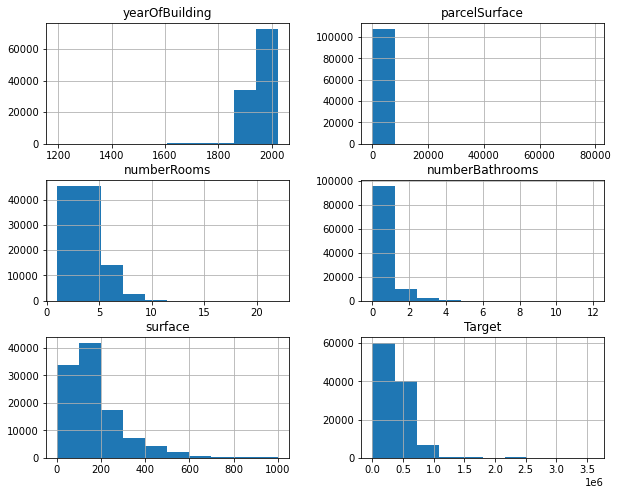

In [64]:
# Rename & extract the variable to predict
target = gt['sellingPrice']
gt.drop(['sellingPrice'],axis = 1 , inplace = True)
gt['Target'] = target

# Overview of feature distribution
gt.hist(figsize = (10,8))
plt.show()

### Split data into train & test

In [65]:
n_train = round(gt.shape[0] * 0.6)
train = gt[:n_train]
test = gt[n_train:]

target = train['Target']
train.drop(['Target'], axis = 1, inplace = True)

truth = test['Target']
test.drop(['Target'], axis = 1, inplace = True)

# 2. Build Neural Network

In [66]:
# Initiate a sequential model (i.e., no recurrence)
NN_model = Sequential()

# Make the first layer
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# Make hidden layers
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# Make the output layer
NN_model.add(Dense(128, kernel_initializer='normal',activation='linear'))

# Compile the network
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error', 'accuracy'])
NN_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_16 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
Total params: 132,480
Trainable params: 132,480
Non-trainable params: 0
_________________________________________________________________


### Checkpoint callback
A backup system that saves the models learned at each epoch.
It saves only the models that are better than the previous models.

A file is made for each new model, containing the weights & biases of each neuron. Any of these files can be loaded to instantiate the corresponding network.

In [67]:
# Define how to name the files
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
# Instantiate the checkpoint system
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

### Train the neural network

In [68]:
history = NN_model.fit(train, target, epochs=100, 
             # No. of randomly sampled data points used to compute the errors at each epoch (avoid overfitting)
             batch_size=50, 
             # Size of validation set for cross-validation
             validation_split = 0.4, 
             # Link to checkpoint system, to check the best model previously built
             callbacks=callbacks_list)

==] - 3s 4ms/step - loss: 20093442048.0000 - mean_absolute_error: 100066.7891 - accuracy: 0.0000e+00 - val_loss: 318510399488.0000 - val_mean_absolute_error: 255021.7344 - val_accuracy: 0.0000e+00
Epoch 56/100
768/778 [============================>.] - ETA: 0s - loss: 19966906368.0000 - mean_absolute_error: 99654.7969 - accuracy: 0.0000e+00
Epoch 00056: val_loss did not improve from 41300271104.00000
778/778 [==============================] - 3s 4ms/step - loss: 19946192896.0000 - mean_absolute_error: 99639.3828 - accuracy: 0.0000e+00 - val_loss: 412249325568.0000 - val_mean_absolute_error: 283247.1250 - val_accuracy: 0.0000e+00
Epoch 57/100
775/778 [============================>.] - ETA: 0s - loss: 19875635200.0000 - mean_absolute_error: 99508.5625 - accuracy: 2.5806e-05
Epoch 00057: val_loss did not improve from 41300271104.00000
778/778 [==============================] - 4s 5ms/step - loss: 19889412096.0000 - mean_absolute_error: 99534.2422 - accuracy: 2.5739e-05 - val_loss: 3167159

### Inspect errors, epoch after epoch

In [50]:
# Retrieve the hitory of every epoch's training
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss  mean_absolute_error      val_loss  val_mean_absolute_error  \
95  1.432179e+10         83151.406250  4.197114e+11             304794.40625   
96  1.388779e+10         82124.828125  4.032785e+11             300086.62500   
97  1.328945e+10         80188.843750  5.162270e+11             330806.09375   
98  1.328970e+10         80174.171875  4.151500e+11             299700.34375   
99  1.296935e+10         79247.289062  4.326538e+11             305228.59375   

    epoch  
95     95  
96     96  
97     97  
98     98  
99     99

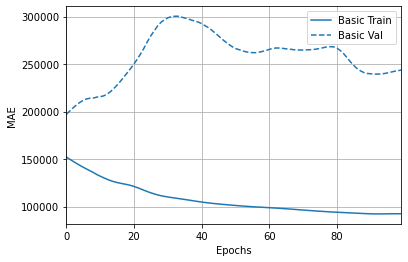

In [69]:
# Plot the evolution of errors epoch after epoch
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mean_absolute_error")
plt.ylabel('MAE')
plt.show()

# 3. Test the Neural Network
First we instantiate the model using the bext parameters from the training phase.

In [70]:
#!# Check best checkpoint in your local folder (the last file saved)
#   Paste the name of the last file saved by tech checkpoint system
weights_file = 'Weights-001--211993919488.00000.hdf5' 

# Load teh parameters of teh models (weights & bias)
NN_model.load_weights(weights_file)
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

ValueError: Shapes (256, 128) and (256, 1) are incompatible

In [53]:
prediction = NN_model.predict(test)

In [54]:
prediction

array([[ 278296.06],
       [ 278296.06],
       [ 278296.06],
       ...,
       [ 654374.4 ],
       [1192130.4 ],
       [2646955.  ]], dtype=float32)

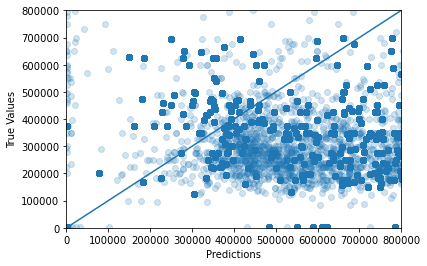

In [55]:
plt.figure()
plt.scatter(prediction, truth, alpha=0.2)
plt.xlabel('Predictions')
plt.ylabel('True Values')
lims = [0, 800000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

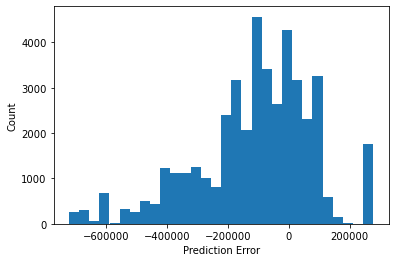

In [56]:
error = prediction - truth.to_numpy()
plt.figure()
plt.hist(error[0], bins = 30)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.show()